# Speeech-to-Text Emergency Call

### Package

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import re
import string
from tqdm import tqdm
from pydub import AudioSegment
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2024-12-01 13:35:17.259898: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 13:35:17.492253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733034917.648129   17942 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733034917.673384   17942 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 13:35:17.869290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print(np.__version__)
print(tf.__version__)

1.26.3
2.18.0


In [3]:
BATCH_SIZE = 32
LR = 1e-4
FRAME_LENGTH = 255
FRAME_STEP = 128
N_EPOCHS = 20

In [4]:
transcripts = pd.read_csv('Dataset/data_wav.csv')

transcripts.head()

,path,sentence
0,common_voice_id_39599471.wav,dia tidak sepenuhnya mempercayaiku
1,common_voice_id_32165882.wav,aku juga tidak mengerti
2,common_voice_id_27657418.wav,berharap kau di sini
3,common_voice_id_23033570.wav,maha suci allah
4,common_voice_id_40088845.wav,pada akhirnya dia memilih anak kucing yang sat...


I0000 00:00:1733034925.445397   17942 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


(76032,)


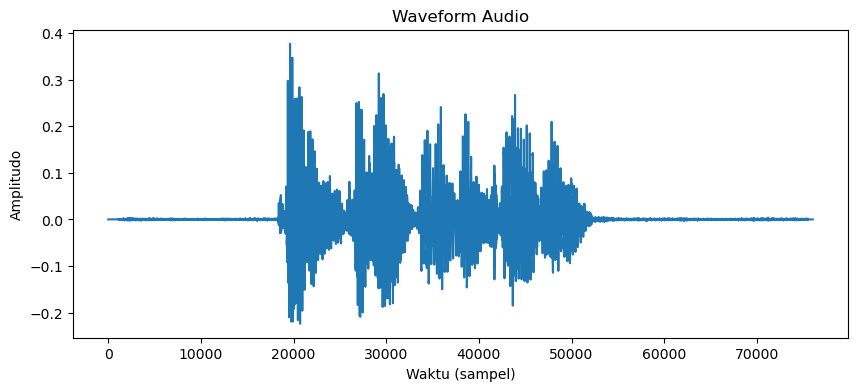

In [5]:
audio_binary = tf.io.read_file("Dataset/clips/common_voice_id_39623919.wav")
audio,_ = tf.audio.decode_wav(audio_binary)
waveform = tf.squeeze(audio, axis=-1)
waveform = tf.cast(waveform, tf.float32)
signal = waveform
print(signal.shape)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title("Waveform Audio")
plt.xlabel("Waktu (sampel)")
plt.ylabel("Amplitudo")
plt.show()

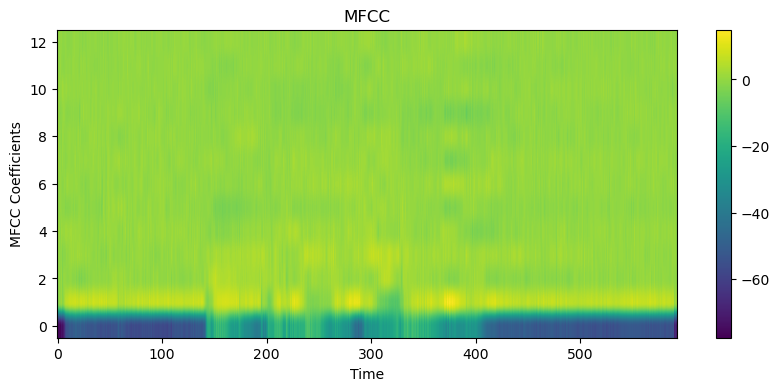

In [6]:
# Parameter STFT dan Mel
frame_length = 256
frame_step = 128
num_mel_bins = 40
num_mfccs = 13

# Ekstraksi STFT dan Mel spectrogram
stft = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
spectrogram = tf.abs(stft)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000
)
mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

# Ekstraksi MFCC
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfccs]

# Plot MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


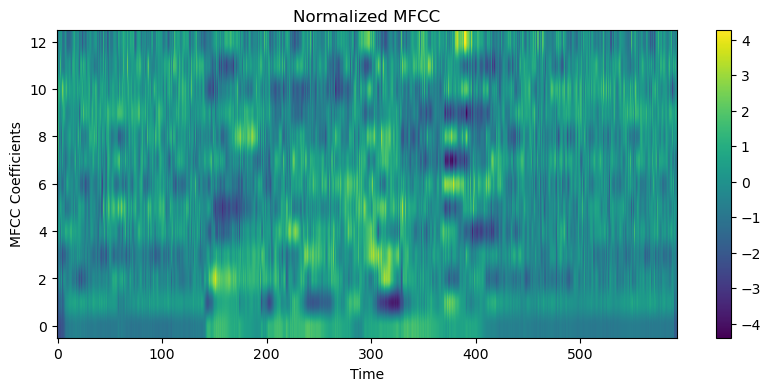

In [7]:
# Normalisasi MFCC
mean_mfcc = tf.reduce_mean(mfccs, axis=0)
std_dev_mfcc = tf.math.reduce_std(mfccs, axis=0)

# Z-score Normalization
normalized_mfccs = (mfccs - mean_mfcc) / (std_dev_mfcc + 1e-6)

# Plot MFCC yang sudah dinormalisasi
plt.figure(figsize=(10, 4))
plt.imshow(normalized_mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("Normalized MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

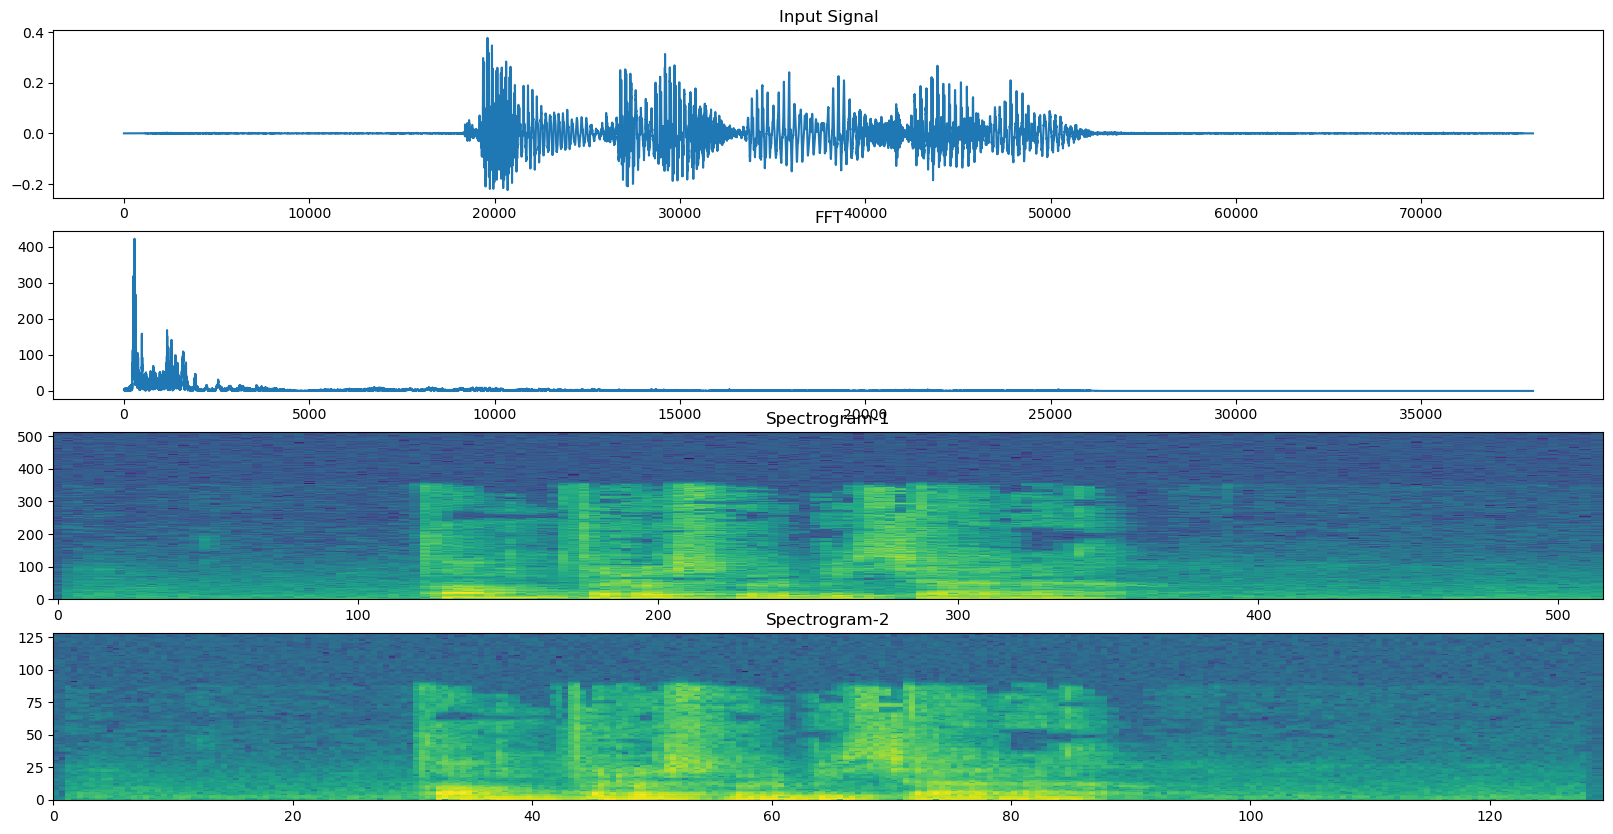

In [8]:
# Membuat 4 subplot dengan ukuran figure 20x10
fig, axis = plt.subplots(4, figsize=(20, 10))

# Definisi panjang sinyal dan sumbu x untuk plotting
L = 2000
x = tf.linspace(-L // 2, L // 2, L)

# Plot sinyal input
axis[0].plot(signal)
axis[0].set_title("Input Signal")

# Menghitung FFT (Fast Fourier Transform) dari sinyal
fft = tf.signal.rfft(signal)

# Plot magnitudo FFT
axis[1].plot(tf.abs(fft))
axis[1].set_title("FFT")

# Menghitung dan memvisualisasikan spektrogram dengan frame_length 1024
spec = tf.signal.stft(signal, frame_length=1024, frame_step=512)
spec = tf.transpose(tf.abs(spec), [1, 0])  # Transpose untuk format visualisasi
power_spec = np.log(spec)  # Mengambil logaritma untuk representasi power
height = power_spec.shape[0]
width = power_spec.shape[1]

# Membuat mesh grid untuk plotting spektrogram
X = np.linspace(0, power_spec.shape[0], num=width, dtype=int)
Y = range(height)

# Plot spektrogram pertama
axis[2].pcolormesh(X, Y, power_spec)
axis[2].set_title("Spectrogram-1")

# Menghitung dan memvisualisasikan spektrogram dengan frame_length 256
spec = tf.signal.stft(signal, frame_length=256, frame_step=128)
spec = tf.transpose(tf.abs(spec), [1, 0])
power_spec = np.log(spec)
height = power_spec.shape[0]
width = power_spec.shape[1]

# Membuat mesh grid untuk plotting spektrogram kedua
X = np.linspace(0, power_spec.shape[0], num=width, dtype=int)
Y = range(height)

# Plot spektrogram kedua
axis[3].pcolormesh(X, Y, power_spec)
axis[3].set_title("Spectrogram-2")

# Menampilkan semua plot
plt.show()


In [9]:
import csv

csv_path = "Dataset/filtered_data_wav.csv"
audio_text = {}

# Membuka file CSV
with open(csv_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for line in reader:
        i = line[0]  # Mendapatkan kolom path audio
        text = line[1]  # Mendapatkan kolom transkript
        audio_text[str(i)] = text  # Menyimpan ke dictionary

# Menampilkan 5 item pertama dari dictionary
list(audio_text.items())[:5]


[('common_voice_id_23033570.wav', 'maha suci allah'),
 ('common_voice_id_20425643.wav', 'inilah dunia kecil'),
 ('common_voice_id_22185104.wav', 'nol'),
 ('common_voice_id_25649959.wav', 'dengarkan aku'),
 ('common_voice_id_27389019.wav', 'ada seekor kucing')]

In [10]:
# list file audio
filepaths = ["Dataset/clips/" + filename for filename in list(audio_text.keys())]

# list transkript
sentence = [text for text in audio_text.values()]

print(len(filepaths))
print(len(sentence))

3349
3349


In [11]:
# Membuat dataset dari pasangan file audio dan transkripsi teks
dataset = tf.data.Dataset.from_tensor_slices((filepaths, sentence))

In [12]:
# print 1 element dari dataset
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Dataset/clips/common_voice_id_23033570.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'maha suci allah'>)


2024-12-01 13:35:29.988106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# decode file audio
def decode_audio(audio_binary):
    # Decode file audio dari format biner menjadi tensor audio
    audio,_=tf.audio.decode_wav(audio_binary)
    # Menghapus dimensi tambahan (-1) agar menghasilkan tensor 1D
    return tf.squeeze(audio, axis=-1)


In [14]:
# Membuat daftar vocabulary untuk pengkodean tekz
vocabulary = [""] + [chr(i) for i in range(97, 97 + 26)]
print(vocabulary ) 
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27


In [15]:
# mengonversi teks (label) menjadi representasi numerik berdasarkan vocabulary
def get_label(label):
    # Memisahkan string menjadi karakter Unicode
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    
    # Mengonversi karakter ke indeks numerik berdasarkan vocabulary
    # Menggunakan StringLookup untuk mencocokkan setiap karakter ke indeks di vocabulary
    # oov_token="" digunakan untuk karakter yang tidak ada dalam vocabulary
    label = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    
    return label



In [16]:
# menghasilkan spektrogram dari file audio dan mengonversi label ke bentuk numerik
def get_spec(filepath, label):
    # Membaca file audio
    audio_binary = tf.io.read_file(filepath)
    
    # Dekode file audio wav menjadi waveform
    waveform = decode_audio(audio_binary)
    
    # Mengonversi waveform ke tipe data float32
    waveform = tf.cast(waveform, tf.float32)
    
    # Menghitung spektrogram dengan Short-Time Fourier Transform (STFT)
    spectrogram = tf.signal.stft(waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    
    # Mengambil magnitudo dari spektrogram
    spectrogram = tf.abs(spectrogram)
    
    # Mengonversi label teks menjadi numerik dengan fungsi get_label
    label = get_label(label)
    
    # Return spektrogram dengan dimensi tambahan (-1) dan label
    return tf.expand_dims(spectrogram, axis=-1), label


In [17]:
# Proses dataset dengan menerapkan fungsi get_spec untuk menghasilkan spektrogram dan label
processed_dataset = (
    # Mengaplikasikan fungsi get_spec ke setiap elemen dalam dataset
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    # Mengelompokkan data menjadi batch dengan ukuran yang ditentukan oleh BATCH_SIZE
    .padded_batch(BATCH_SIZE)
    # Mengoptimalkan pembacaan data dengan prefetching untuk mempercepat proses
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [18]:
# # spectrogram shapes
# for spectrogram, label in processed_dataset.take(1):
#     print(f"Spectrogram shape: {spectrogram.shape}")
#     print(f"Label shape: {label.shape}")

In [19]:
# Membagi dataset yang telah diproses menjadi dataset untuk pelatihan dan validasi
train_dataset = processed_dataset.take(int(0.95 * len(processed_dataset)))
val_dataset = processed_dataset.skip(int(0.95 * len(processed_dataset)))

In [20]:
print("Train cardinality:", train_dataset.cardinality().numpy())
print("Validation cardinality:", val_dataset.cardinality().numpy())


Train cardinality: 99
Validation cardinality: 6


In [21]:
# Mengambil dan menampilkan elemen pertama dari train_dataset
for i, j in train_dataset.take(1):
    print(i, j)

tf.Tensor(
[[[[7.12660898e-04]
   [5.13789884e-04]
   [1.44733902e-04]
   ...
   [6.85862324e-05]
   [6.57396813e-05]
   [5.59415785e-05]]

  [[1.42830051e-03]
   [6.93136302e-04]
   [6.96829447e-05]
   ...
   [5.38312852e-05]
   [4.78865586e-05]
   [1.28585321e-04]]

  [[1.95925543e-03]
   [8.81103624e-04]
   [1.21866695e-04]
   ...
   [1.01327190e-04]
   [9.45074862e-05]
   [1.57851027e-05]]

  ...

  [[3.43429740e-03]
   [4.82161017e-03]
   [3.62441293e-03]
   ...
   [3.18618841e-05]
   [7.54037756e-05]
   [1.12323789e-04]]

  [[5.79476822e-03]
   [2.55878642e-03]
   [1.93130446e-03]
   ...
   [1.50654480e-04]
   [1.25587918e-04]
   [8.92605167e-05]]

  [[9.98278707e-03]
   [5.08701243e-03]
   [3.75536561e-04]
   ...
   [2.62180056e-05]
   [3.94400304e-05]
   [2.23275274e-05]]]


 [[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.0000

2024-12-01 13:35:30.532547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
# Membuat layer normalisasi dari Keras
normalization = tf.keras.layers.Normalization()

In [23]:
# Input layer untuk spektrogram dengan bentuk (None, 129, 1), yang berarti 
# panjang variabel, 129 fitur frekuensi, dan 1 saluran (mono)
input_spectrogram = Input((None, 129, 1), name="input")

# Normalisasi input spektrogram untuk memastikan data memiliki distribusi yang seragam
x = normalization(input_spectrogram)

# Convolutional Layer pertama: 32 filter dengan ukuran kernel (11, 41), strides (2, 2),
# padding 'same' untuk mempertahankan dimensi input, dan fungsi aktivasi ReLU
x = Conv2D(32, kernel_size=[11, 41], strides=[2, 2], padding='same', activation='relu')(x)

# Layer normalisasi untuk output dari Conv2D
x = LayerNormalization()(x)

# Convolutional Layer kedua: 64 filter dengan ukuran kernel (11, 21), strides (1, 2),
# padding 'same', dan fungsi aktivasi ReLU
x = Conv2D(64, kernel_size=[11, 21], strides=[1, 2], padding='same', activation='relu')(x)

# Layer normalisasi untuk output dari Conv2D kedua
x = LayerNormalization()(x)

# Mengubah bentuk output dari Conv2D untuk memasukkan data ke dalam layer Recurrent
x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

# Bidirectional GRU Layer pertama dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Bidirectional GRU Layer kedua dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Bidirectional GRU Layer ketiga dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Dense layer untuk output dengan jumlah unit sebanyak panjang vocabulary + 1 (untuk token OOV),
# menggunakan fungsi aktivasi softmax untuk klasifikasi multi-kelas
output = Dense(len(vocabulary) + 1, activation="softmax")(x)

# Membuat model dengan input spektrogram dan output hasil prediksi
model = tf.keras.Model(input_spectrogram, output, name="Speech_to_text")

# Menampilkan ringkasan arsitektur model
model.summary()


Model: "Speech_to_text"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 129, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, None, 129, 1)   │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, 65, 32)   │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 65, 32)   │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, 33, 64)   │       473,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 33, 64)   │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 2112)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │     1,721,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 256)      │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 28)       │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,809,759 (10.72 MB)

 Trainable params: 2,809,756 (10.72 MB)

 Non-trainable params: 3 (16.00 B)

In [24]:
def ctc_loss(y_true,y_pred):
    batch_size = tf.shape(y_pred)[0]
    pred_length = tf.shape(y_pred)[1]
    true_length = tf.shape(y_true)[1]

    pred_length = pred_length * tf.ones([batch_size,1], dtype=tf.int32)
    true_length = true_length * tf.ones([batch_size,1], dtype=tf.int32)

    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, pred_length, true_length)

In [25]:
model.compile(
    loss = ctc_loss,  # Menggunakan custom CTC loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),  # Menggunakan Adam optimizer
)

In [ ]:
history = model.fit(
    train_dataset,  # Data pelatihan
    validation_data = val_dataset,  # Data validasi
    verbose = 1,  # Menampilkan progres pelatihan
    epochs = N_EPOCHS  # Jumlah epoch untuk pelatihan
)

Epoch 1/20


I0000 00:00:1733034937.559224   22979 cuda_dnn.cc:529] Loaded cuDNN version 90501


 1/99 ━━━━━━━━━━━━━━━━━━━━ 1:20:18 49s/step - loss: 3114.5698

In [ ]:
def get_spec_inference(filepath):

  audio_binary = tf.io.read_file(filepath)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform,tf.float32)

  spectrogram = tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram = tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [ ]:
test_path = "Dataset/clips/common_voice_id_23033570.wav"

In [ ]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

(2096, 129, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


In [ ]:
out

<tf.Tensor: shape=(1048,), dtype=int64, numpy=array([11,  1, 27, ..., 27, 27, 27])>

In [ ]:
out_list = [vocabulary[i] if i != 27 else "[LINK]" for i in out]
out_str = "".join(out_list)

In [ ]:
print(out_str)

ka[LINK][LINK][LINK][LINK]a[LINK][LINK][LINK][LINK]a[LINK][LINK][LINK]sa[LINK][LINK][LINK][LINK]a[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LI

In [ ]:
def decode(y_pred):
  batch_size = tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length = tf.shape(y_pred)[1]
  pred_length *= tf.ones([batch_size,], dtype=tf.int32)

  y_pred = tf.one_hot(y_pred,len(vocabulary)+1)
  output = tf.keras.backend.ctc_decode(y_pred, input_length=pred_length, greedy=True)[0][0]

  out = [vocabulary[i] for i in output[0]]
  return ''.join(out)

In [ ]:
print(decode(tf.expand_dims(out,axis=0)))

tf.Tensor([   1 1048], shape=(2,), dtype=int32)
kaaasaazzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz